In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import mplhep as hep
import os
import analysis as ana

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from  sklearn.preprocessing import label_binarize
import shap

In [4]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"
plots_dir = "plots"

In [32]:
# File paths for signal and background root files: 
electron_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/ElectronPU200gen_filtered.h5"
electron_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/ElectronPU200cl3d_filtered.h5"
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonsPU200gen_filtered.h5"
photon_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonsPU200cl3d_filtered.h5"
qcdPU200_df = pd.read_hdf("/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/output_matched.h5", key="matched")
neutrino_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/cl3d_filtered_neutrino.h5"
neutrino_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/gen_filtered_neutrino.h5"
pions_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PionsPU200gen_filtered.h5"
pions_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PionsPU200cl3d_filtered.h5"

In [33]:
electronPU200_df = ana.load_and_filter_hdf(electron_PU200_gen, electron_PU200_cl3d)

In [34]:
photonPU200_df = ana.load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d)

In [35]:
neutrinoPU200_df = ana.load_and_filter_hdf('None', neutrino_PU200_cl3d)

In [36]:
pionsPU200_df = ana.load_and_filter_hdf(pions_PU200_gen, pions_PU200_cl3d)

In [37]:
photonPU200_df_filtered = ana.filter_by_delta_r(photonPU200_df, 0.05)

In [38]:
neutrinoPU200_df_20GeV = neutrinoPU200_df[neutrinoPU200_df['cl3d_pt'] > 20]

Saved plot as: plots/delta_r_vs_etaenergy_Photon_PU200.png


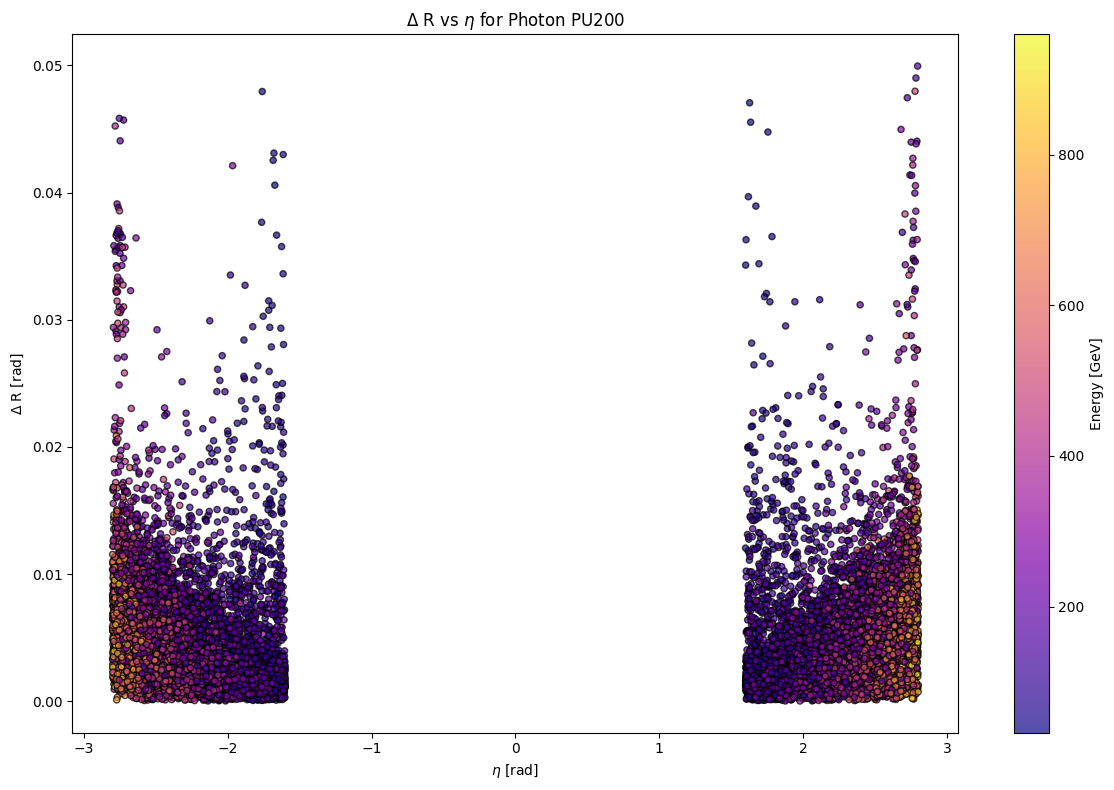

In [12]:
ana.plot_delta_r_3d_two_dfs(photonPU200_df_filtered, 'Photon PU200', plots_dir, colors=('blue', 'red'))

Saved plot as: plots/delta_r_vs_etaenergy_Photon_PU200.png


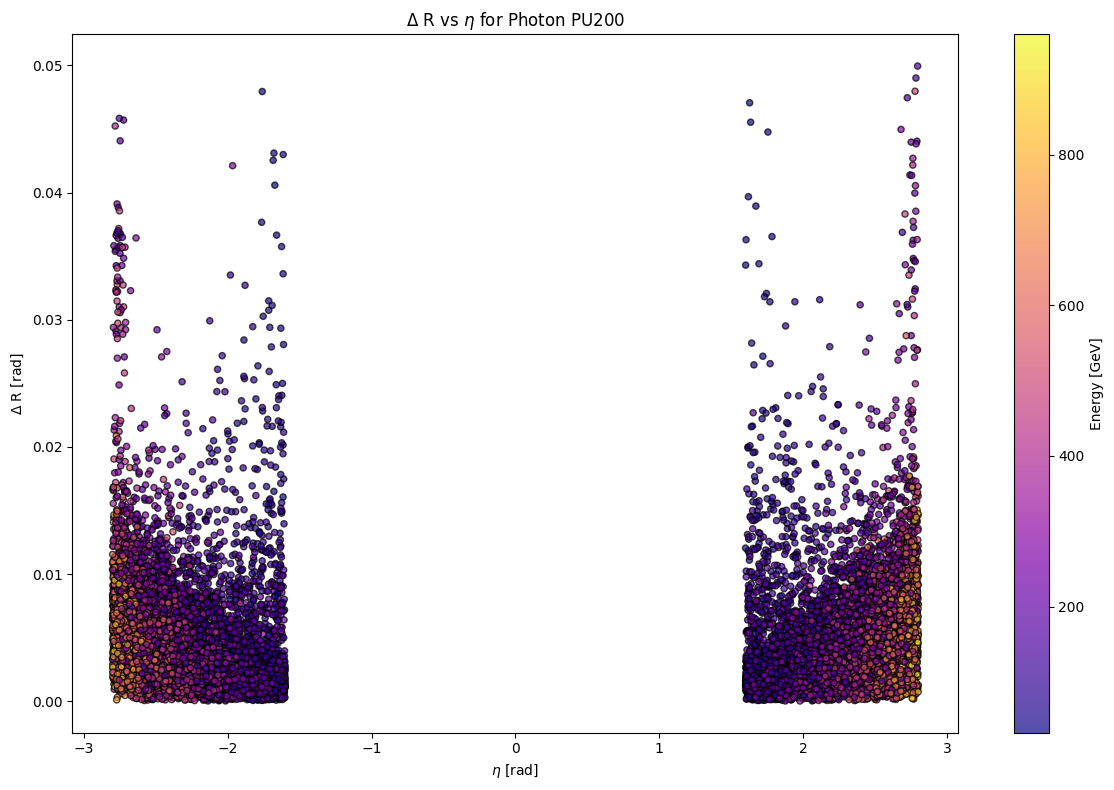

In [13]:
ana.plot_delta_r_3d_two_dfs(photonPU200_df_filtered, 'Photon PU200', plots_dir, colors=('blue', 'red'))

In [39]:
variables = ['cl3d_pt', 'cl3d_energy', 'cl3d_eta', 'cl3d_emax1layers', 'cl3d_emax3layers',
       'cl3d_phi', 'cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
       'cl3d_varrr', 'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_hoe',
       'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90',
       'cl3d_first1layers', 'cl3d_first3layers', 'cl3d_first5layers',
       'cl3d_firstHcal1layers', 'cl3d_firstHcal3layers',
       'cl3d_firstHcal5layers', 'cl3d_last1layers', 'cl3d_last3layers',
       'cl3d_last5layers', 'cl3d_eot', 'cl3d_ebm0', 'cl3d_ebm1']#, 'cl3d_hbm']

var_latex_map = {
    'cl3d_pt': r'$p_T$ [GeV]',
    'cl3d_energy': 'Energy [GeV]',
    'cl3d_eta': r'$\eta$',
    'cl3d_emax1layers': 'Emax1layers',
    'cl3d_emax3layers': 'Emax3layers',
    'cl3d_phi': r'$\phi$',
    'cl3d_showerlength': 'Shower Length',
    'cl3d_coreshowerlength': 'Core Shower Length',
    'cl3d_firstlayer': 'First Layer',
    'cl3d_maxlayer': 'Max Layer',
    'cl3d_varrr': '$\sigma^2_{rr}$',
    'cl3d_varzz': '$\sigma^2_{zz}$',
    'cl3d_varee': '$\sigma^2_{\eta\eta}$',
    'cl3d_varpp': '$\sigma^2_{\phi\phi}$',
    'cl3d_emaxe': '$E^{max}/E$',
    'cl3d_hoe': 'CE-H/CE-E',
    'cl3d_meanz': 'Mean Z',
    'cl3d_layer10': 'Layer 10',
    'cl3d_layer50': 'Layer 50',
    'cl3d_layer90': 'Layer 90',
    'cl3d_first1layers': 'Fraction of energy in first 1 Layer',
    'cl3d_first3layers': 'Fraction of energy in first 3 Layers',
    'cl3d_first5layers': 'Fraction of energy in first 5 Layers',
    'cl3d_firstHcal1layers': 'Fraction of energy in first Hcal 1 Layer',
    'cl3d_firstHcal3layers': 'Fraction of energy in first Hcal 3 Layers',
    'cl3d_firstHcal5layers': 'Fraction of energy in first Hcal 5 Layers',
    'cl3d_last1layers': 'Fraction of energy in last 1 Layer',
    'cl3d_last3layers': 'Fraction of energy in last 3 Layers',
    'cl3d_last5layers': 'Fraction of energy in last 5 Layers',
    'cl3d_eot' : 'E /Total E', 
    'cl3d_ebm0': 'Cluster EBM0', 
    'cl3d_ebm1': 'Cluster EBM1', 
    #'cl3d_hbm' : 'Cluster HBM',
    'gen_pt' : r'$p_T^{Gen.}$ [GeV]',
    'genjet_pt' : r'$p_T^{Gen. Jet}$ [GeV]'
}

Saved: plots/cl3d_pt_histogram.png


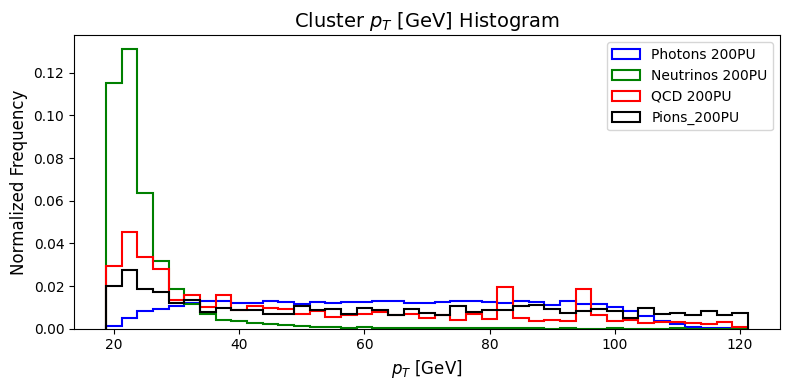

Saved: plots/cl3d_energy_histogram.png


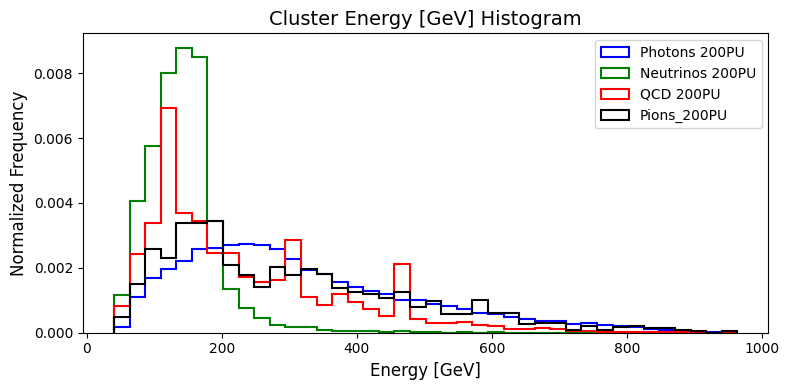

Saved: plots/cl3d_eta_histogram.png


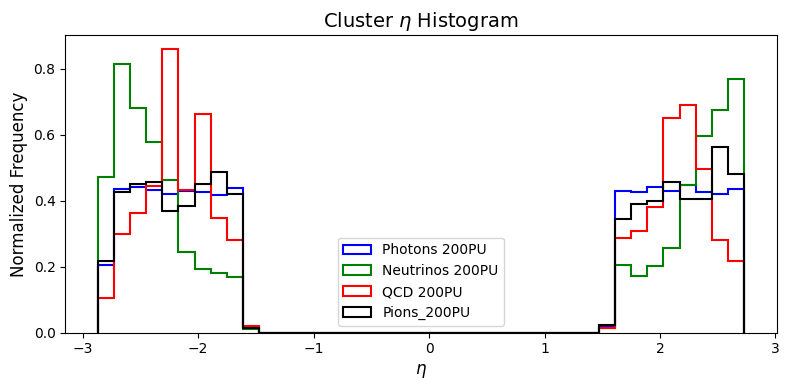

Saved: plots/cl3d_emax1layers_histogram.png


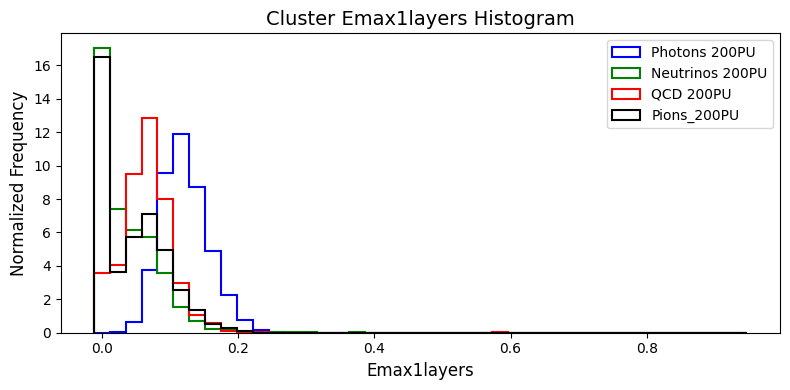

Saved: plots/cl3d_emax3layers_histogram.png


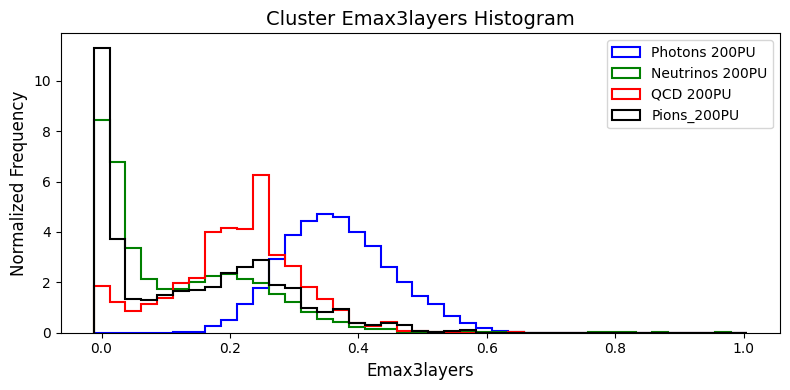

Saved: plots/cl3d_phi_histogram.png


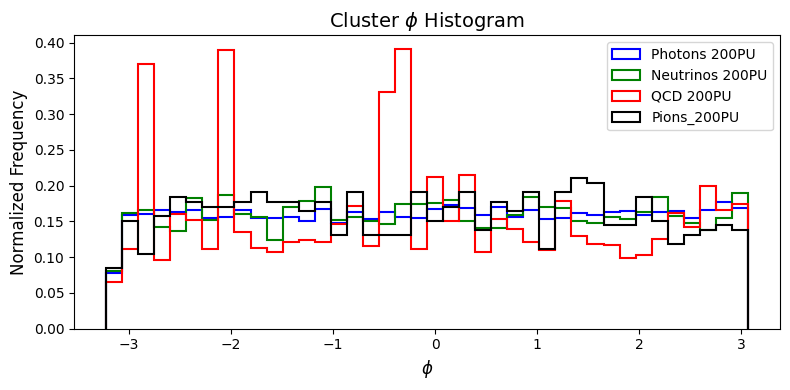

Saved: plots/cl3d_showerlength_histogram.png


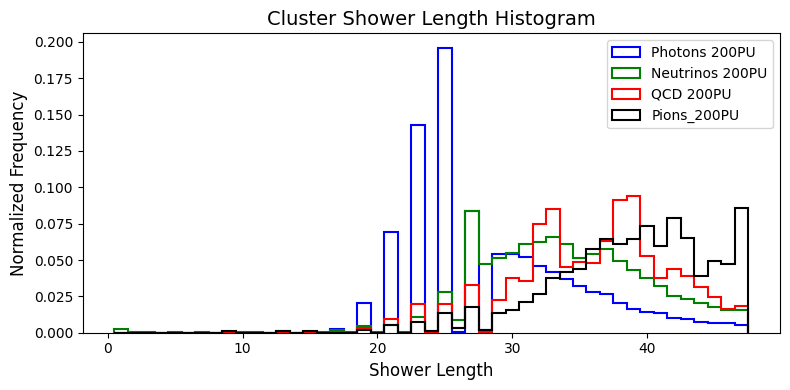

Saved: plots/cl3d_coreshowerlength_histogram.png


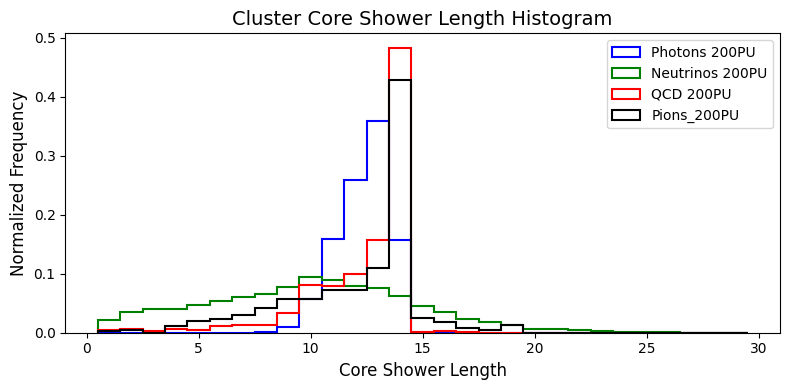

Saved: plots/cl3d_firstlayer_histogram.png


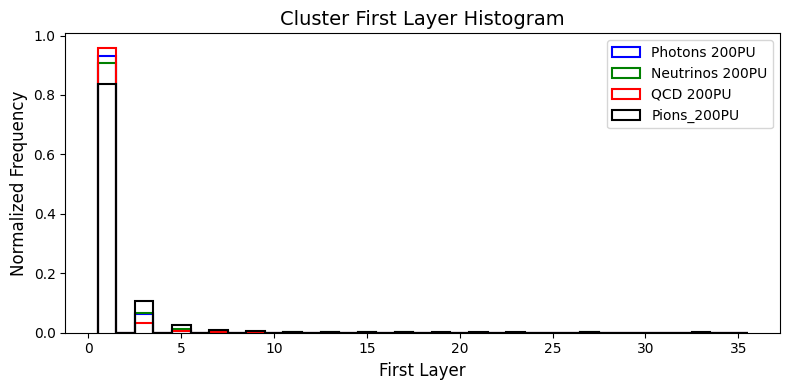

Saved: plots/cl3d_maxlayer_histogram.png


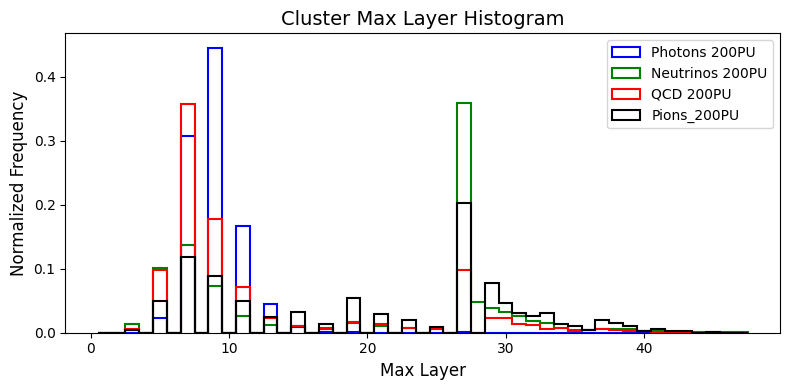

Saved: plots/cl3d_varrr_histogram.png


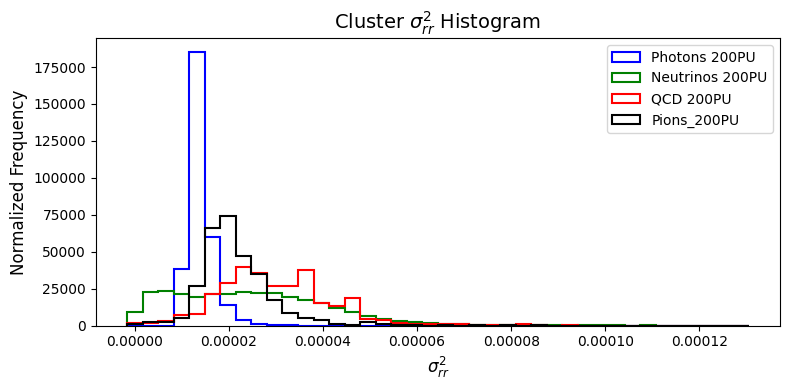

Saved: plots/cl3d_varzz_histogram.png


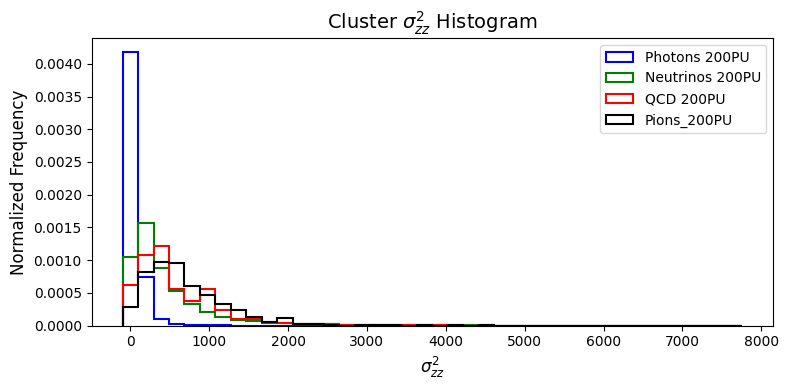

Saved: plots/cl3d_varee_histogram.png


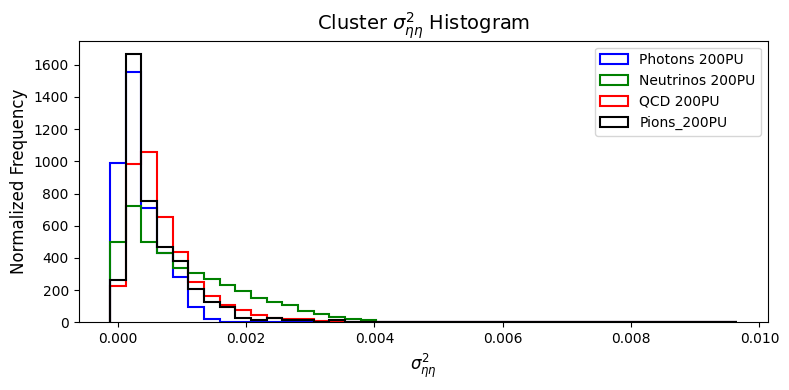

Saved: plots/cl3d_varpp_histogram.png


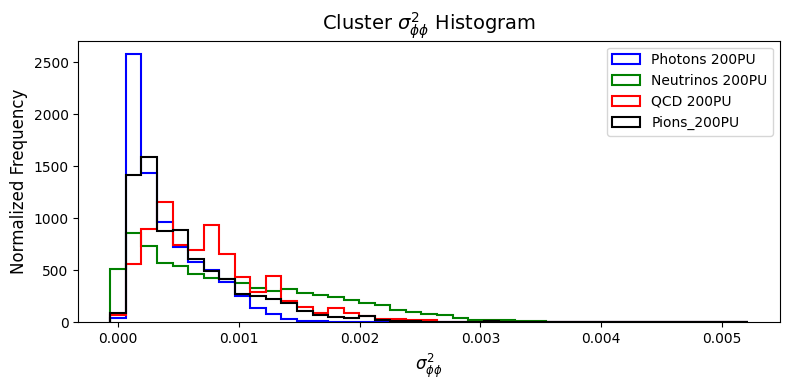

Saved: plots/cl3d_emaxe_histogram.png


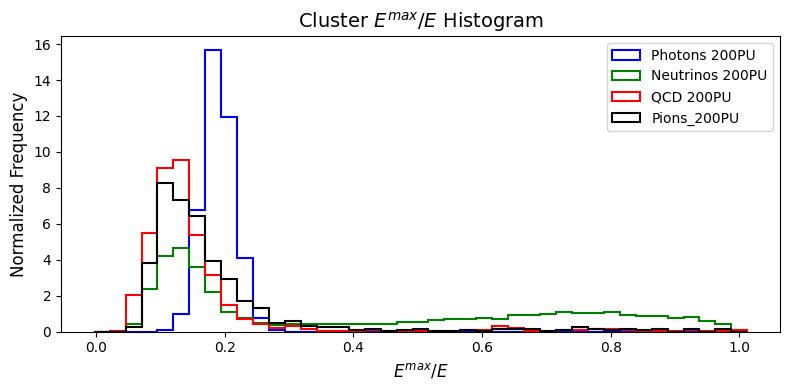

Saved: plots/cl3d_hoe_histogram.png


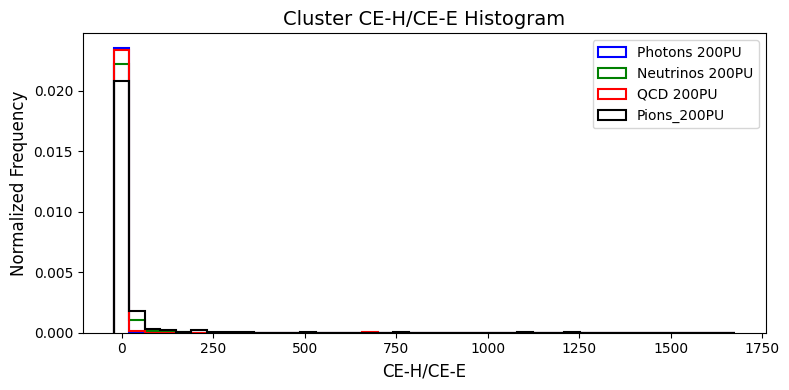

Saved: plots/cl3d_meanz_histogram.png


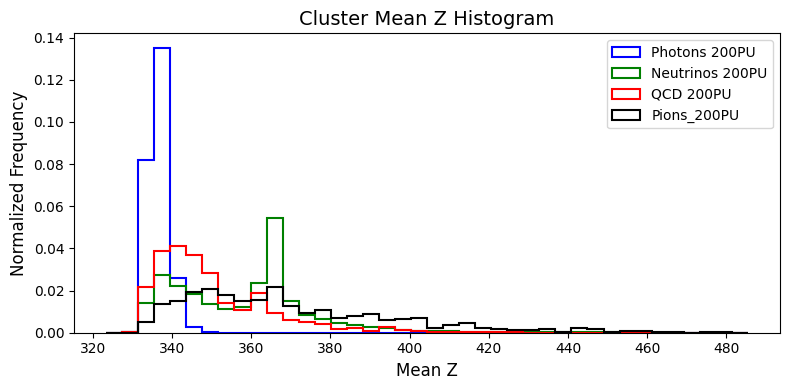

Saved: plots/cl3d_layer10_histogram.png


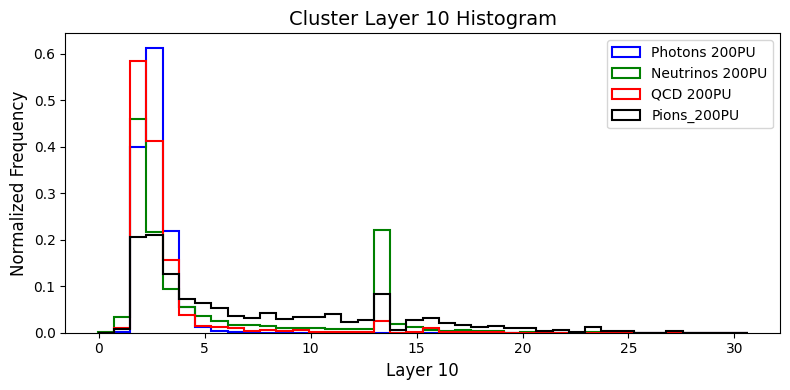

Saved: plots/cl3d_layer50_histogram.png


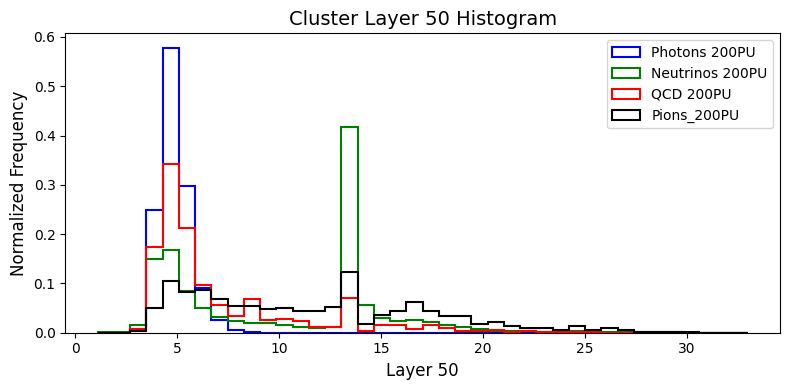

Saved: plots/cl3d_layer90_histogram.png


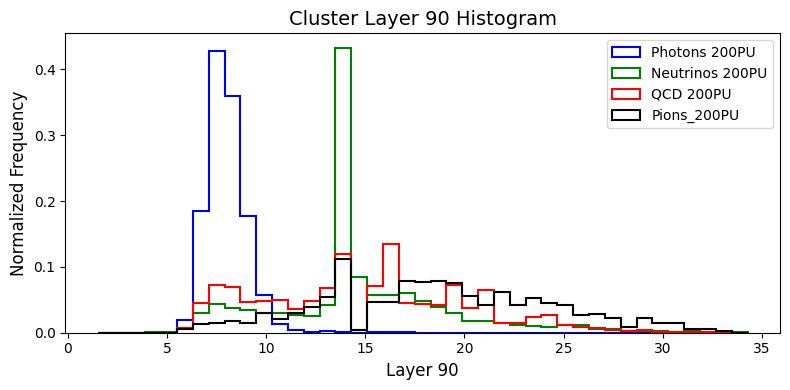

Saved: plots/cl3d_first1layers_histogram.png


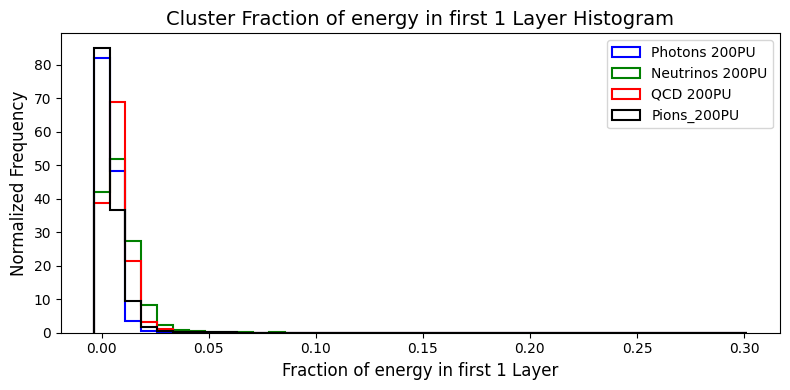

Saved: plots/cl3d_first3layers_histogram.png


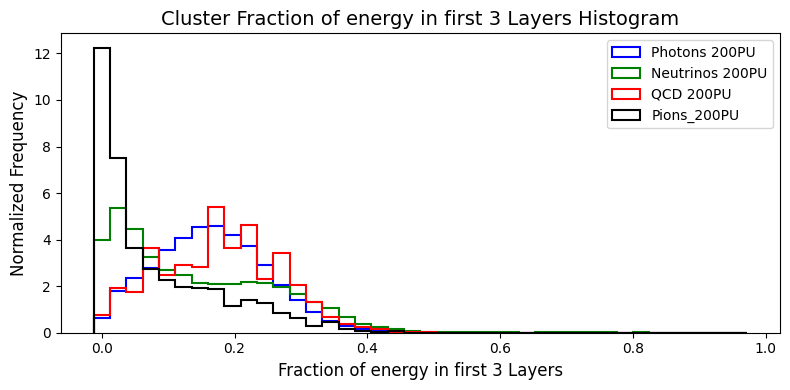

Saved: plots/cl3d_first5layers_histogram.png


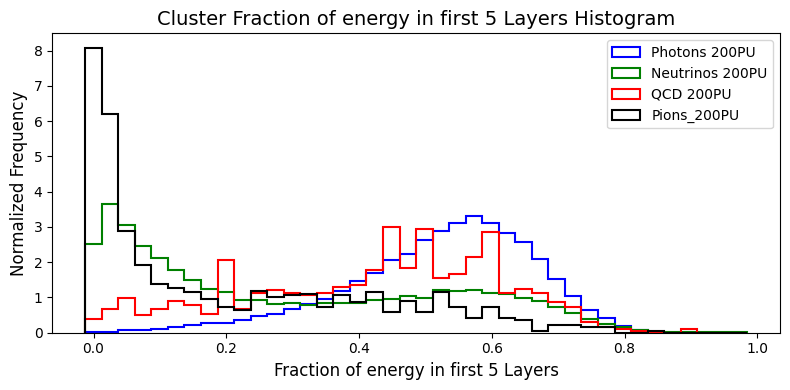

Saved: plots/cl3d_firstHcal1layers_histogram.png


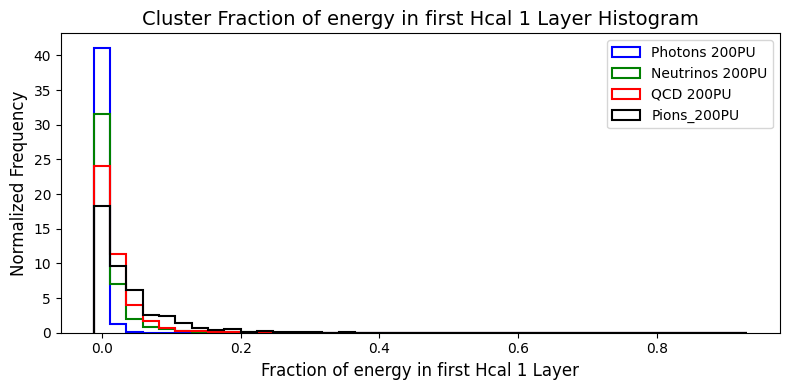

Saved: plots/cl3d_firstHcal3layers_histogram.png


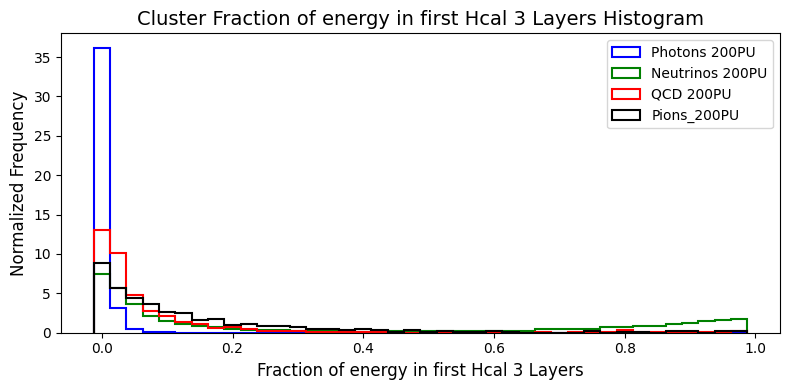

Saved: plots/cl3d_firstHcal5layers_histogram.png


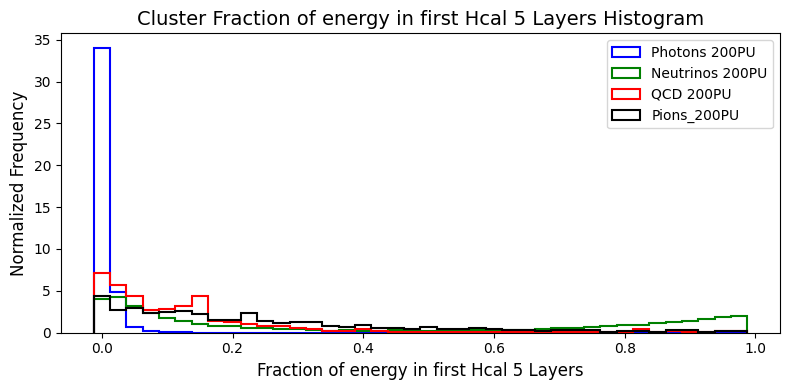

Saved: plots/cl3d_last1layers_histogram.png


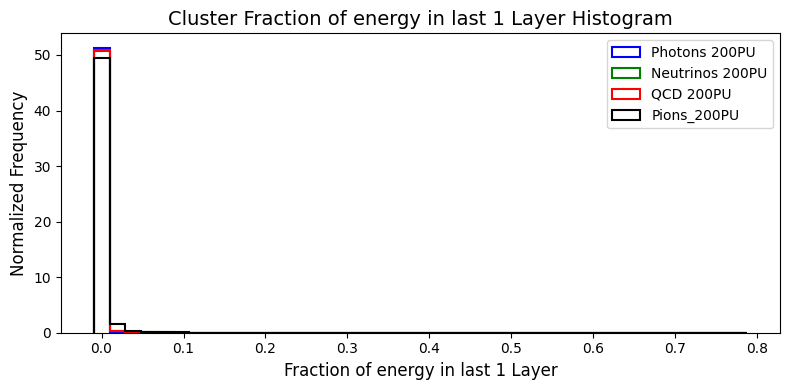

Saved: plots/cl3d_last3layers_histogram.png


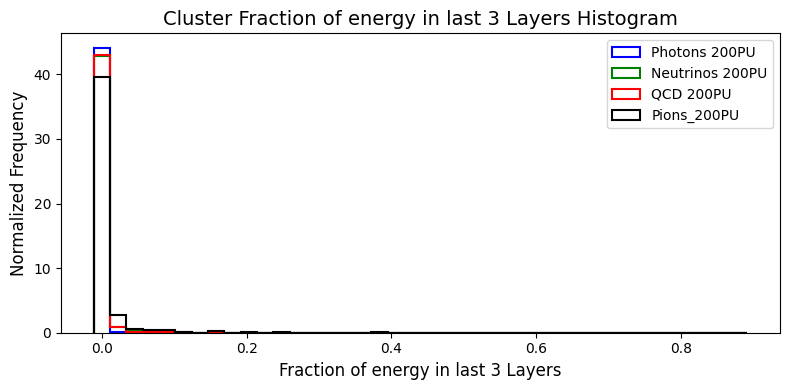

Saved: plots/cl3d_last5layers_histogram.png


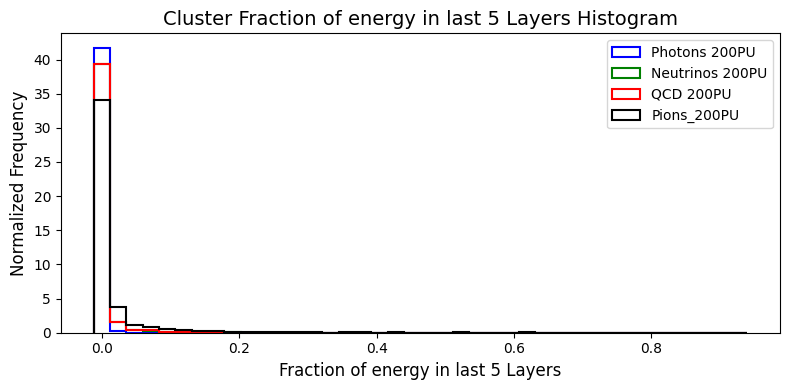

Saved: plots/cl3d_eot_histogram.png


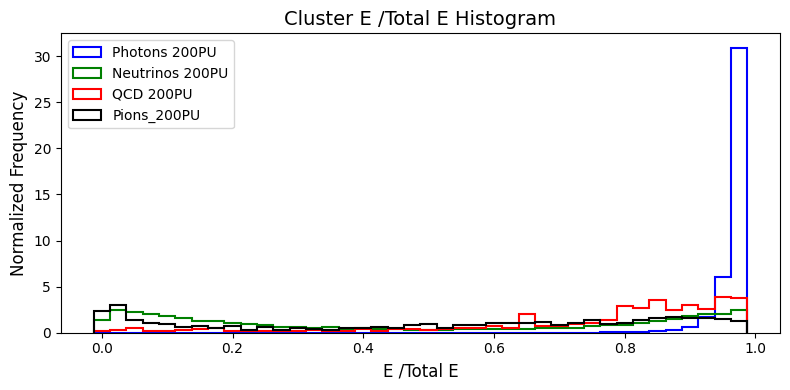

Saved: plots/cl3d_ebm0_histogram.png


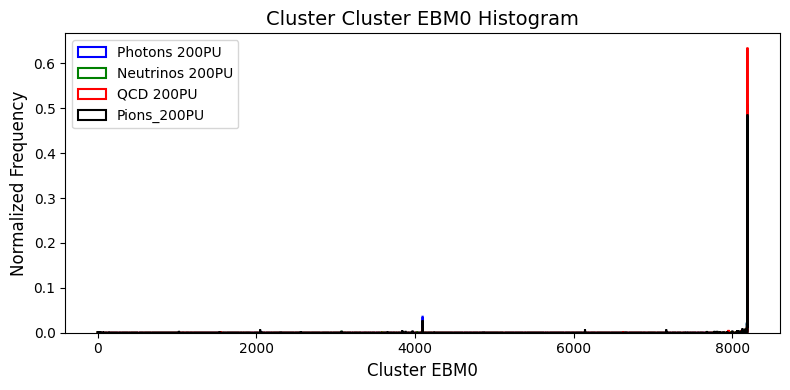

Saved: plots/cl3d_ebm1_histogram.png


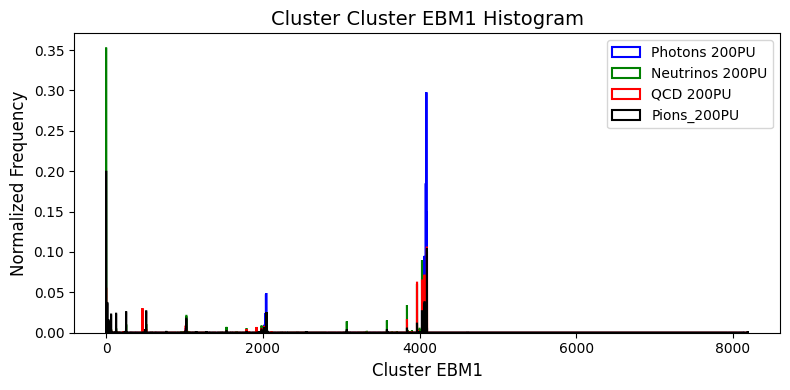

In [40]:
ana.plot_histograms(photonPU200_df_filtered, neutrinoPU200_df_20GeV, df_matched, pionsPU200_df, variables, 'Photons 200PU', 'Neutrinos 200PU', 'QCD 200PU', 'Pions_200PU', plots_dir, var_latex_map)

In [35]:
X = filtered_data[columns_for_training]
y = filtered_data['label']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
def objective(trial, X_train, y_train, X_test, y_test):
    """
    Optuna objective function to optimize XGBoost hyperparameters while keeping memory usage optimized.
    """
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "use_label_encoder": False,
        "n_estimators": 100,  # Fixed to avoid excessive memory usage
        "max_depth": trial.suggest_int("max_depth", 1, 4),  # Reduced max depth
        "learning_rate": 0.005,  
        "colsample_bytree": 0.8,  # Fixed value
        "subsample": 0.8,         # Fixed value
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    # Evaluate using AUC
    y_pred = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred)

In [ ]:
# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=500, n_jobs=1)
print(f"Best parameters: {study.best_params}")

In [57]:
# Train final model with the best parameters
best_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "use_label_encoder": False,
        "n_estimators": 100,  # Fixed to avoid excessive memory usage
        "max_depth": 4,
        "learning_rate": 0.005,  
        "colsample_bytree": 0.8,  # Fixed value
        "subsample": 0.8,         # Fixed value
        "gamma": 4.9,
        "reg_lambda": 1,
        "reg_alpha": 0.7
}
best_params.update({"n_jobs": 20})  # Optionally update with additional parameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=4.9, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=20, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [5]:
qcd_pt20to30_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD20to30gen_filtered.h5"
qcd_pt20to30_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD20to30cl3d_filtered.h5"
qcd_pt30to50_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD30to50gen_filtered.h5"
qcd_pt30to50_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD30to50cl3d_filtered.h5"
qcd_pt50to80_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD50to80gen_filtered.h5"
qcd_pt50to80_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD50to80cl3d_filtered.h5"
qcd_pt80to120_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD80to120gen_filtered.h5"
qcd_pt80to120_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD80to120cl3d_filtered.h5"
qcd_pt120to170_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD120to170gen_filtered.h5"
qcd_pt120to170_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD120to170cl3d_filtered.h5"
qcd_pt170to300_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD170to300gen_filtered.h5"
qcd_pt170to300_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD170to300cl3d_filtered.h5"
'''qcd_pt300toInf_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD300toInfgen_filtered.h5"
qcd_pt300toInf_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD300toInfcl3d_filtered.h5"'''

'qcd_pt300toInf_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD300toInfgen_filtered.h5"\nqcd_pt300toInf_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/testQCD300toInfcl3d_filtered.h5"'

# 

In [13]:
qcd_pt20to30_PU200 = ana.load_and_filter_hdf(qcd_pt20to30_PU200_gen, qcd_pt20to30_PU200_cl3d)

In [14]:
qcd_pt30to50_PU200 = ana.load_and_filter_hdf(qcd_pt30to50_PU200_gen, qcd_pt30to50_PU200_cl3d)

In [15]:
qcd_pt50to80_PU200 = ana.load_and_filter_hdf(qcd_pt50to80_PU200_gen, qcd_pt50to80_PU200_cl3d)

In [16]:

qcd_pt80to120_PU200 = ana.load_and_filter_hdf(qcd_pt80to120_PU200_gen, qcd_pt80to120_PU200_cl3d)

In [17]:
qcd_pt120to170_PU200 = ana.load_and_filter_hdf(qcd_pt120to170_PU200_gen, qcd_pt120to170_PU200_cl3d)

In [18]:
qcd_pt170to300_PU200 = ana.load_and_filter_hdf(qcd_pt170to300_PU200_gen, qcd_pt170to300_PU200_cl3d)

In [19]:
qcd_pt20to30_PU200 = qcd_pt20to30_PU200[(qcd_pt20to30_PU200['gen_status'] == 1) & (qcd_pt20to30_PU200['cl3d_pt'] > 20)]
qcd_pt30to50_PU200 = qcd_pt30to50_PU200[(qcd_pt30to50_PU200['gen_status'] == 1) & (qcd_pt30to50_PU200['cl3d_pt'] > 20)]
qcd_pt50to80_PU200 = qcd_pt50to80_PU200[(qcd_pt50to80_PU200['gen_status'] == 1) & (qcd_pt50to80_PU200['cl3d_pt'] > 20)]
qcd_pt80to120_PU200 = qcd_pt80to120_PU200[(qcd_pt80to120_PU200['gen_status'] == 1) & (qcd_pt80to120_PU200['cl3d_pt'] > 20)]

In [20]:
qcd_pt20to30_PU200

,event,gen_n,gen_eta,gen_phi,gen_pt,gen_energy,gen_pdgid,gen_status,genpart_exphi,genpart_exeta,...,cl3d_eot,cl3d_ebm0,cl3d_ebm1,cl3d_hbm,cl3d_ntc67,cl3d_ntc90,cl3d_bdteg,cl3d_quality,cl3d_ipt,cl3d_ienergy
852,4030563,1256,6.767857,2.509849,0.153631,66.787117,-211,1,-1.625895,-1.875308,...,0.066339,7884,0,1048576,0.717606,0.963948,-0.998945,0,0.000000,0.000000
853,4030563,1256,6.767857,2.509849,0.153631,66.787117,-211,1,-1.625895,-1.875308,...,0.066339,7884,0,1048576,0.717606,0.963948,-0.998945,0,33.105347,152.066650
854,4030563,1256,5.989354,-1.718866,0.327186,65.299866,211,1,-3.051202,-1.042772,...,0.066339,7884,0,1048576,0.717606,0.963948,-0.998945,0,0.000000,0.000000
855,4030563,1256,5.989354,-1.718866,0.327186,65.299866,211,1,-3.051202,-1.042772,...,0.066339,7884,0,1048576,0.717606,0.963948,-0.998945,0,33.105347,152.066650
856,4030563,1256,7.464515,2.219514,0.850159,741.767578,-211,1,2.009027,-2.935924,...,0.066339,7884,0,1048576,0.717606,0.963948,-0.998945,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15650429,3545837,2049,-0.194092,-1.661474,1.259224,1.590259,-2112,1,1.190541,-1.948260,...,0.317901,8181,3584,3162112,1.981894,32.850739,-0.998888,0,34.804188,235.586288
15650432,3545837,2049,-0.896324,-0.508721,0.463966,1.148968,2212,1,-0.750004,3.111670,...,0.317901,8181,3584,3162112,1.981894,32.850739,-0.998888,0,0.000000,0.000000
15650433,3545837,2049,-0.896324,-0.508721,0.463966,1.148968,2212,1,-0.750004,3.111670,...,0.317901,8181,3584,3162112,1.981894,32.850739,-0.998888,0,34.804188,235.586288
15650434,3545837,2049,-1.368923,-2.298231,1.621866,3.521801,-2112,1,-1.728916,-2.879550,...,0.317901,8181,3584,3162112,1.981894,32.850739,-0.998888,0,0.000000,0.000000


NameError: name 'var_latex_map' is not defined

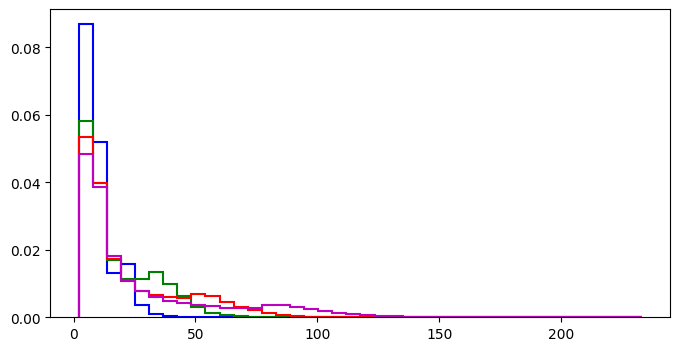

In [ ]:
ana.plot_qcd_histograms(qcd_pt20to30_PU200, qcd_pt30to50_PU200, qcd_pt50to80_PU200, qcd_pt80to120_PU200, ['gen_pt', 'cl3d_pt'])

In [21]:
# Replace with your real numbers
sample_info = {
    "qcd_pt20to30_PU200": {"df": qcd_pt20to30_PU200, "xsec": 5.5e6, "nevt": 165},
    "qcd_pt30to50_PU200": {"df": qcd_pt30to50_PU200, "xsec": 7.5e6,  "nevt": 169},
    "qcd_pt50to80_PU200": {"df": qcd_pt50to80_PU200, "xsec": 1.96e6,  "nevt": 136},
    "qcd_pt80to120_PU200": {"df": qcd_pt80to120_PU200, "xsec": 4.19e5,  "nevt": 162},
    "qcd_pt120to170_PU200": {"df": qcd_pt120to170_PU200, "xsec": 4.9e6,  "nevt": 360},
    "qcd_pt170to300_PU200": {"df": qcd_pt170to300_PU200, "xsec": 4.48e6,  "nevt": 328}
}

In [22]:
dfs = []
for key, info in sample_info.items():
    df = info["df"].copy()
    base_weight = info["xsec"] / info["nevt"]
    df["base_weight"] = base_weight
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

In [23]:
# Compute histogram of gen_pt (weighted by base_weight)
hist, bin_edges = np.histogram(df_all["gen_pt"], bins=50, weights=df_all["base_weight"], density=True)
bin_indices = np.digitize(df_all["gen_pt"], bin_edges) - 1
bin_indices = np.clip(bin_indices, 0, len(hist) - 1)

# Compute inverse PDF weight
inv_pdf = 1.0 / hist[bin_indices]
df_all["flat_weight"] = df_all["base_weight"] * inv_pdf

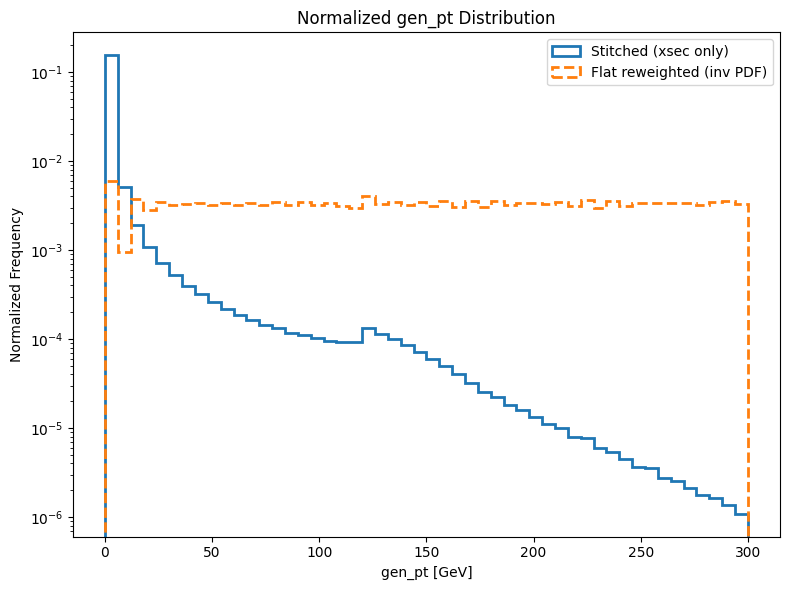

In [27]:
bins = 50
range_pt = (0, 300)
plt.figure(figsize=(8, 6))
plt.hist(df_all["gen_pt"], bins=bins, range=range_pt, weights=df_all["base_weight"], density=True, histtype='step', label='Stitched (xsec only)', linewidth=2)
plt.hist(df_all["gen_pt"], bins=bins, range=range_pt, weights=df_all["flat_weight"], density=True, histtype='step', label='Flat reweighted (inv PDF)', linewidth=2, linestyle='dashed')
plt.xlabel("gen_pt [GeV]")
plt.ylabel("Normalized Frequency")
plt.yscale('log')
plt.title("Normalized gen_pt Distribution")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
def gen_match_clusters_to_photons(df, delta_r_threshold=0.5):
    required_cols = ['cl3d_eta', 'cl3d_phi', 'cl3d_ienergy',
                     'genpart_exeta', 'genpart_exphi',
                     'gen_pdgid', 'gen_status']

    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Missing columns. Required: {required_cols}")

    df = df.copy()

    # Keep only gen photons with status == 1
    df = df[(df['gen_pdgid'] == 22) & (df['gen_status'] == 1)]

    # Compute deltaR
    df['delta_r'] = ana.delta_r(df['cl3d_eta'], df['cl3d_phi'],
                            df['genpart_exeta'], df['genpart_exphi'])

    # Keep only clusters matched to a photon within ΔR threshold
    df_matched = df[df['delta_r'] < delta_r_threshold].copy()

    return df_matched

In [29]:
df_matched = gen_match_clusters_to_photons(df_all)

In [30]:
df_matched

,event,gen_n,gen_eta,gen_phi,gen_pt,gen_energy,gen_pdgid,gen_status,genpart_exphi,genpart_exeta,...,cl3d_hbm,cl3d_ntc67,cl3d_ntc90,cl3d_bdteg,cl3d_quality,cl3d_ipt,cl3d_ienergy,base_weight,flat_weight,delta_r
634,4035652,325,7.691325,-3.140248,0.236373,258.742523,22,1,2.974360,-2.326480,...,65536,32.357422,65.598808,-0.979485,0,0.000000,0.000000,33333.333333,3.912940e+05,0.331608
635,4035652,325,7.691325,-3.140248,0.236373,258.742523,22,1,2.974360,-2.326480,...,65536,32.357422,65.598808,-0.979485,0,20.213856,99.310417,33333.333333,3.912940e+05,0.331608
13508,4143812,677,5.386865,-0.855794,0.088273,9.644744,22,1,0.282039,2.277560,...,3145728,0.819642,7.635280,-0.998923,0,0.000000,0.000000,33333.333333,3.912940e+05,0.389790
13509,4143812,677,5.386865,-0.855794,0.088273,9.644744,22,1,0.282039,2.277560,...,3145728,0.819642,7.635280,-0.998923,0,35.248039,242.769287,33333.333333,3.912940e+05,0.389790
13522,4143812,677,1.580791,1.648170,0.155787,0.394501,22,1,0.383395,2.833086,...,3145728,0.819642,7.635280,-0.998923,0,0.000000,0.000000,33333.333333,3.912940e+05,0.233318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137520031,241229,802,-5.702281,0.267538,0.143995,21.567146,22,1,-0.509763,1.942878,...,3276800,43.777573,98.734444,-0.704127,2,79.582848,283.850311,13658.536585,1.603351e+05,0.055627
137520032,241229,802,1.949083,-0.526157,7.358253,26.359659,22,1,-0.444758,1.946242,...,3276800,43.777573,98.734444,-0.704127,2,0.000000,0.000000,13658.536585,1.603351e+05,0.120620
137520033,241229,802,1.949083,-0.526157,7.358253,26.359659,22,1,-0.444758,1.946242,...,3276800,43.777573,98.734444,-0.704127,2,79.582848,283.850311,13658.536585,1.603351e+05,0.120620
137520034,241229,802,1.949901,-0.538724,15.612135,55.971661,22,1,-0.496949,1.944530,...,3276800,43.777573,98.734444,-0.704127,2,0.000000,0.000000,13658.536585,8.110867e+06,0.068417


In [31]:
df_matched.to_hdf("output_matched.h5", key="matched", mode="w")